<a href="https://colab.research.google.com/github/dayanakhadijah/DLCV-Workshop-Assignments/blob/main/DLCV_Assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
!gdown https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip

Downloading...
From: https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip
To: /content/gdrive/MyDrive/fruit_dataset_exercise.zip
100% 10.6M/10.6M [00:00<00:00, 112MB/s]


In [ ]:
!unzip  fruit_dataset_exercise.zip -d /content/gdrive/MyDrive/fruit_dataset

Archive:  fruit_dataset_exercise.zip
   creating: /content/gdrive/MyDrive/fruit_dataset/train/durian/
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/durian/durian28.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/durian/durian33.jpg  
   creating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/0024ef4511cb07be8ccd234b7143304d64899744.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/0066c2ae111450ba6a6ef03486657b58252e6e1f.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/01556c59f720c859217328371036cd6ec1d78732.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/065ae0e728e01e9aacd0c9bc7f37f826ba82fe89.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/083227f662dbc1739041e9e4e1775a049c51606f.jpg  
  inflating: /content/gdrive/MyDrive/fruit_dataset/train/pumpkin/092d44f61e6d704fc5245a06bc25b80af47b003a.jpg  
  

In [ ]:
!rm -rf /content/fruit_dataset_exercise.zip

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
    ])
}

In [ ]:
dataset = '/content/gdrive/MyDrive/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 64

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

4
{0: 'durian', 1: 'pumpkin', 2: 'tomato', 3: 'watermelon'}


In [ ]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'model1_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#To check the details of the model
from torchsummary import summary
print(summary(model_ft,(3,224,224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
num_epochs = 20
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 0.2275, Accuracy: 90.5950%, 
		Validation : Loss : 1.3283, Accuracy: 78.9474%, Time: 4.8227s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.2589, Accuracy: 89.6353%, 
		Validation : Loss : 1.0907, Accuracy: 76.4706%, Time: 4.6621s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.1965, Accuracy: 91.1708%, 
		Validation : Loss : 0.9938, Accuracy: 81.4241%, Time: 4.5881s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.1444, Accuracy: 94.0499%, 
		Validation : Loss : 0.6695, Accuracy: 83.5913%, Time: 4.7910s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.1344, Accuracy: 92.8983%, 
		Validation : Loss : 0.8725, Accuracy: 81.7337%, Time: 4.6771s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.1411, Accuracy: 92.5144%, 
		Validation : Loss : 0.9200, Accuracy: 81.4241%, Time: 4.7152s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.1310, Accuracy: 93.0902%, 
		Validation : Loss : 0.9307, Accuracy: 83.9009%, Time: 4.6918s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.1384, Accuracy: 92.

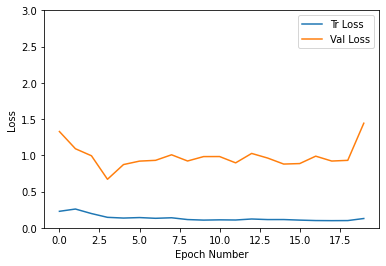

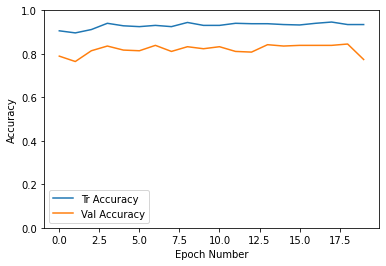

In [ ]:
# 5. Analyze the loss curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

**BASIC MODEL MODIFICATION**

In [ ]:
class CustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.fc1 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64, eps = 1e-2)
        self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(64, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1) #the viewing function means flattening for linear
       # and also our new layers. 
        output = self.dp(self.bn1(self.relu(self.fc0(output))))
        output = self.dp(self.bn2(self.relu(self.fc1(output))))
        output = self.classifier(output)
        return output
    


In [ ]:
model = CustomResnet18()

# 2. LOSS AND OPTIMIZER
criterion2 = nn.CrossEntropyLoss()
optimizer_model = optim.Adam(model.parameters(), lr=0.001)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResnet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
num_epochs = 20
trained_model, history = train_and_validate(model, criterion2, optimizer_model, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 1.0845, Accuracy: 65.0672%, 
		Validation : Loss : 1.7875, Accuracy: 46.7492%, Time: 4.6222s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.6465, Accuracy: 79.4626%, 
		Validation : Loss : 0.9747, Accuracy: 74.6130%, Time: 4.5731s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.5626, Accuracy: 83.1094%, 
		Validation : Loss : 1.0357, Accuracy: 78.0186%, Time: 5.5572s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.4515, Accuracy: 86.7562%, 
		Validation : Loss : 0.9597, Accuracy: 62.5387%, Time: 4.7164s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.3451, Accuracy: 88.8676%, 
		Validation : Loss : 0.7546, Accuracy: 79.5666%, Time: 4.6699s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.3533, Accuracy: 88.8676%, 
		Validation : Loss : 0.6780, Accuracy: 78.9474%, Time: 4.8293s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.4011, Accuracy: 86.7562%, 
		Validation : Loss : 1.3793, Accuracy: 71.2074%, Time: 4.8870s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.5023, Accuracy: 84.

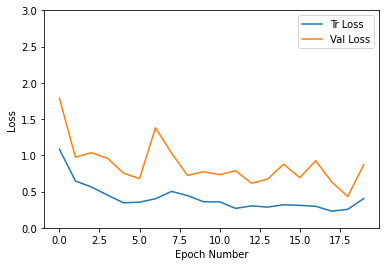

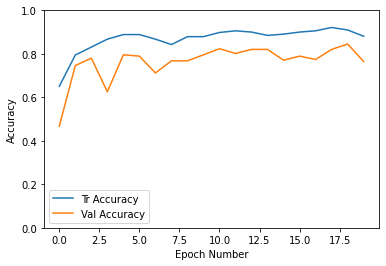

In [ ]:
# 5. Analyze the loss curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

**DATA-CENTRIC STRATEGY**


*   To remove the misplaced data in classes
*   To add more data in the dataset
*   To make sure the data ar in the point of focus



In [ ]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
    ])
}

In [ ]:
dataset = '/content/gdrive/MyDrive/fruits_dataset_updated/'
train_directory = os.path.join('/content/gdrive/MyDrive/fruits_dataset_updated/train')
test_directory = os.path.join('/content/gdrive/MyDrive/fruits_dataset_updated/validation')

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

4


In [ ]:
data['train']

Dataset ImageFolder
    Number of datapoints: 521
    Root location: /content/gdrive/MyDrive/fruits_dataset_updated/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [ ]:
data['test']

Dataset ImageFolder
    Number of datapoints: 323
    Root location: /content/gdrive/MyDrive/fruits_dataset_updated/validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [ ]:
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=16, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'model_datacentric'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
mnetv2 = models.resnet101(pretrained=True)
mnetv2

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        axnet = models.alexnet(pretrained=pretrained)
        self.features = nn.ModuleList(axnet.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = axnet.classifier[1].in_features

        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
        output = self.dp(self.bn1(self.relu(self.fc0(output))))
        output = self.classifier(output)
        return output

In [ ]:
model_datacentric = CustomModel()

# 2. LOSS AND OPTIMIZER
criterion3 = nn.CrossEntropyLoss()
optimizer_modeldc = optim.Adam(model_datacentric.parameters(), lr=0.001)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_datacentric.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomModel(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (fc0): Linear(in_features=9216, out_features=256, bias=True)
  (bn1): BatchNo

In [ ]:
num_epochs = 20
trained_model, history = train_and_validate(model_datacentric, criterion3, optimizer_modeldc, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 1.0418, Accuracy: 66.4107%, 
		Validation : Loss : 1.1506, Accuracy: 68.4211%, Time: 4.2214s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.6836, Accuracy: 78.6948%, 
		Validation : Loss : 0.7423, Accuracy: 77.7090%, Time: 4.1984s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.6355, Accuracy: 80.2303%, 
		Validation : Loss : 3.8382, Accuracy: 40.5573%, Time: 4.2799s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.5901, Accuracy: 82.3417%, 
		Validation : Loss : 1.5947, Accuracy: 61.9195%, Time: 4.2809s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.4852, Accuracy: 83.4933%, 
		Validation : Loss : 0.9916, Accuracy: 71.2074%, Time: 4.2739s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.4630, Accuracy: 85.0288%, 
		Validation : Loss : 0.9699, Accuracy: 76.7802%, Time: 4.2490s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.4392, Accuracy: 85.7965%, 
		Validation : Loss : 0.8307, Accuracy: 71.2074%, Time: 4.2723s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.4519, Accuracy: 85.

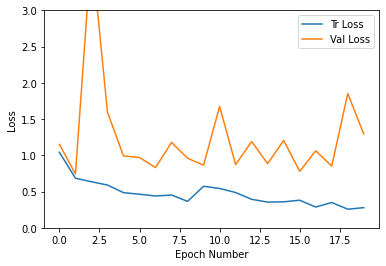

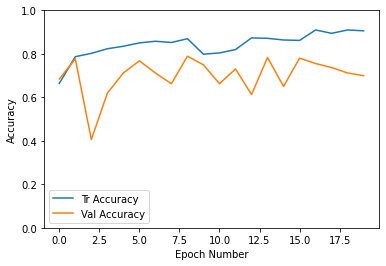

In [ ]:
# 5. Analyze the loss curve
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.show()

# 6. Analyze the accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [43]:
from requests import get

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

In [44]:
!wget https://upload.wikimedia.org/wikipedia/commons/8/89/Tomato_je.jpg -O picture1.jpg

file_name = "picture1.jpg"

--2022-07-30 18:56:44--  https://upload.wikimedia.org/wikipedia/commons/8/89/Tomato_je.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238015 (232K) [image/jpeg]
Saving to: ‘picture1.jpg’

picture1.jpg        100%[===================>] 232.44K  --.-KB/s    in 0.008s  

2022-07-30 18:56:44 (28.4 MB/s) - ‘picture1.jpg’ saved [238015/238015]



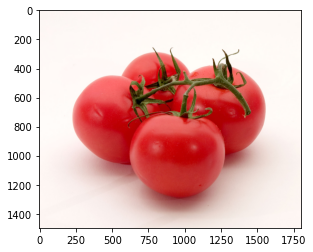

In [45]:
import cv2
img = cv2.imread("picture1.jpg")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

In [46]:
model_datacentric.eval()

CustomModel(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (fc0): Linear(in_features=9216, out_features=256, bias=True)
  (bn1): BatchNo

In [47]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
        ])

img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0).to(device)

out = model_datacentric(batch_t)
print(out.shape)

torch.Size([1, 4])


watermelon 0.8566365838050842
tomato 0.13270142674446106
durian 0.007879027165472507
pumpkin 0.0027828984893858433


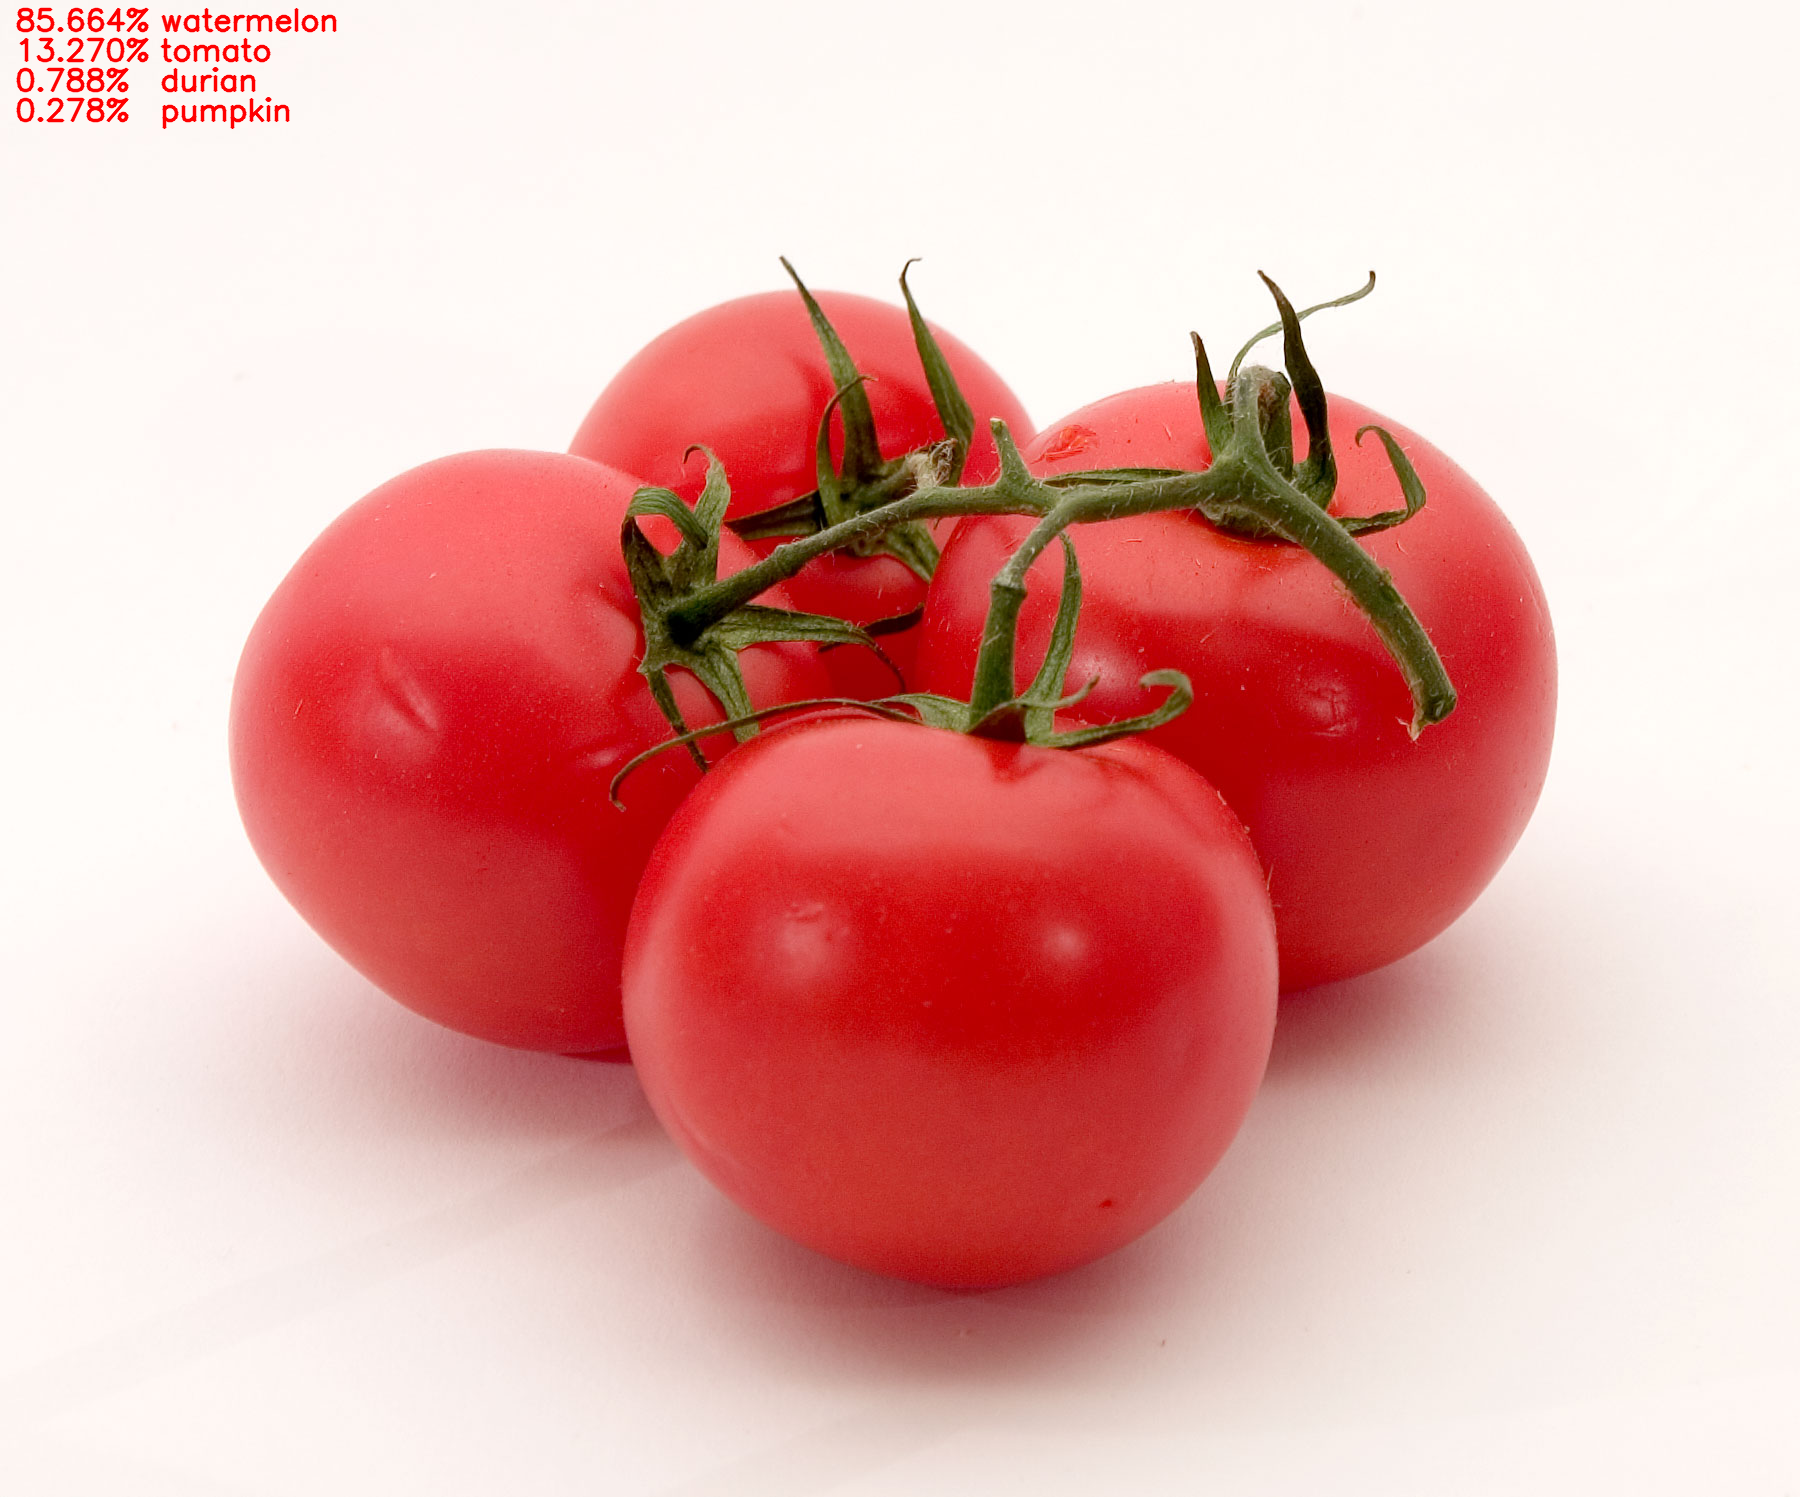

In [48]:
from google.colab.patches import cv2_imshow

classes = ['durian', 'pumpkin', 'tomato', 'watermelon']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 4)

for i in range(top5_prob.size(0)):
    cv2.putText(img, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()